# Capstone Project 1: Data Story

In this section, I present a priliminary exploration of the data for capstone project. I begin with the data <i>csv</i> file, which we obtained after the data wrangling section. As a recall, the data contains mostly categorical variables and components of the vectors from the description column. The index column is a <i>timeseries</i> format. 

The major objective of this section is to understand the general trends in the data, and gain some quick insights and relation between variables that will help in machine learning later. The statistical significance of these observation will be tested in the next section <b> Exploratory Data Analysis</b>. 

In [10]:
# Import necessary modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ipyleaflet 
from ipyleaflet import Map, Heatmap
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import Image
from IPython.core.display import HTML 

# Read the accident data from csv
df_traffic = pd.read_csv('data_wrangled.csv', 
                           index_col = 'Date Of Stop_Time Of Stop',
                           parse_dates = True,
                           infer_datetime_format = True)

Attention Montgomery drivers! You can be pulled over almost everywhere across the city. The most violations occur in the busy streets, highways and their intersection. As an example, here is a heatmap of downtown Silver Spring. In the next paragraph, you will see a more interactive google map showing the street view and the number of pull overs in the last five years (Unfortunately the web browser may not support the map embedded in this blog). 

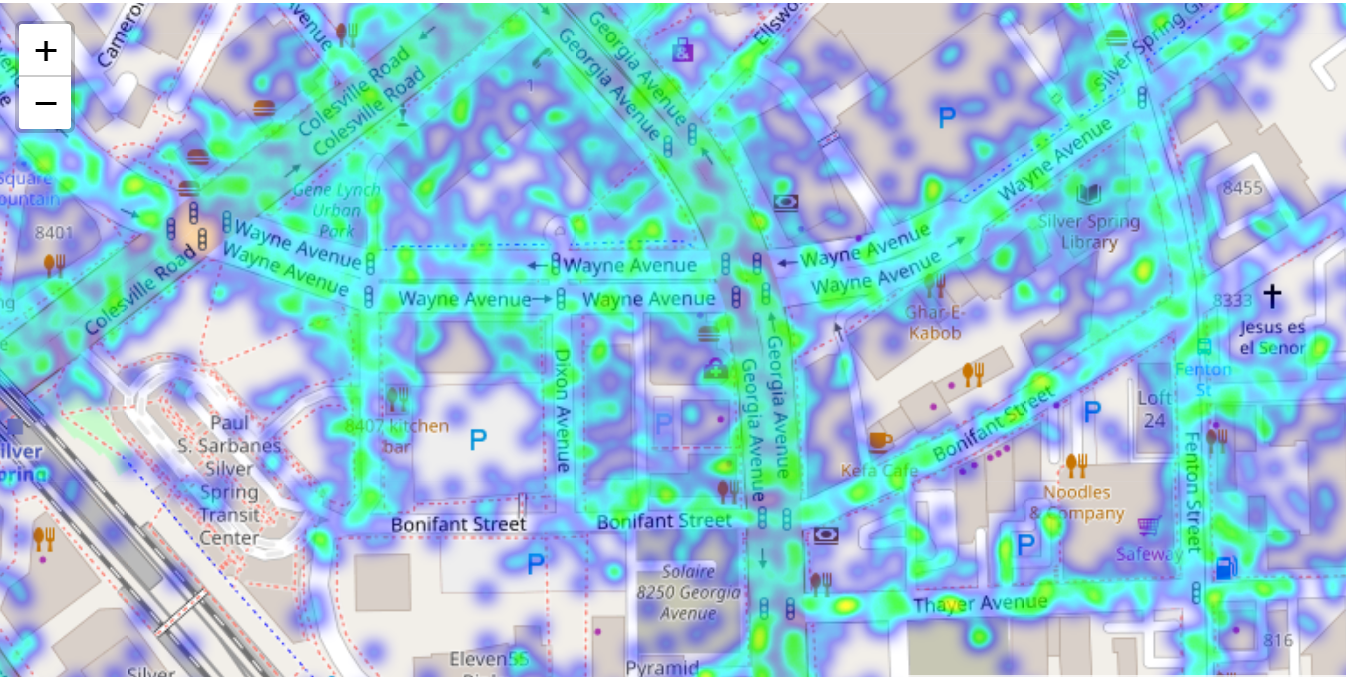

In [11]:
from IPython.core.display import Image, display
display(Image('http://nbviewer.jupyter.org/github/lekhnath12/Capstone-project-I/blob/master/silver_spring.PNG', 
              width=750, unconfined=True))

In [12]:
locn = df_traffic.loc[:,['Latitude', 'Longitude']]
locn['datetime'] = locn.index
locn['hour'] = locn.datetime.dt.hour
locn[(locn.hour >= 7) & (locn.hour <= 9)]
locn = locn.loc[:,['Latitude', 'Longitude']]
locn['wt'] = 10

m = Map(center=(39.0827, -77.1128), zoom = 9)
heatmap = Heatmap(locations=locn.values.tolist(), 
                  max_zoom = 9, radius=5)

m.add_layer(heatmap);

m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

### What are the most common mistake?

Traffic officers keep a note of the violations as a text. But different officers can have different writing styles, variation in details and typos. For each different entry, the computer understands the input differently. Just as an example, use of telephone has been described in several ways. 
<p>
<font color=blue>
DRIVER USING HANDS TO USE HANDHELD TELEPHONE WHILEMOTOR VEHICLE IS IN MOTION<br>
DRIVER USING HANDS TO USE HANDHELD TELEPHONE WHILE MOTOR VEHICLE IS IN MOTION<br>
DRIVER USING HANDS TO USE HANDHELD TELEPHONE WHILEMOTOR VEHICLE IS IN MOTION SECONDARY ACTION  <br>
DRIVER OF A CLASS H VEH CARRYING PASSENGERS AND INMOTION USING HANDHELD PHONE <br> 
HOLDER OF LEARNER'S PERMIT 18 Y/OLDER USING A HANDHELD TELEPHONE WHILE OPER. M/V  <br>
.....<br>
.....<br>
HOLDER OF PROVISIONAL LIC 18 Y/OLDER USING A HANDHELD TELEPHONE WHILE OPER. M/V<br> 
DRIVER USING HANDS TO USE HANDHELD TELEPHONE<br>
DRIVER USING HANDS TO USE HANDHELD TELEPHONE WHILEMOTOR VEHICLE IS IN MOTION.<br>
<font color=black>
   
All the rows primarily tells that the driver was pulled over for using telephone. I used natural language processing to group the similar text together. 

In [20]:
# First convert into vector
corpus = df_traffic.Description

vectorizer = CountVectorizer(stop_words = 'english', 
                             strip_accents = 'ascii', 
                             min_df = 0.0, 
                             max_features = 1000,
                             token_pattern='[a-z]+',
                             max_df = 1.0,
                             binary  = True)

X = vectorizer.fit_transform(corpus)

# then group the dataframe by description column. This compress the size of Series by a 
#factor of 10

df = df_traffic.loc[:, ['Color', 'Description']].groupby('Description').count()
df.sort_values(by = 'Color', ascending = False, inplace = True)

df.rename(index=str, columns={"Color": "Count"}, inplace = True)
df.reset_index(inplace = True)

# change the text into vector array
X = vectorizer.transform(df.Description).toarray()

# This function calculates the similarity of each rows to all other remaining rows, and return 
# the index of dataframe df that are similar. The tuning parameter factor choice. Higher value 
# factor means gives index of columns that are more similar
def matching_text(text_vector, TEXT_ARRAY, factor = 5):
    x1 = np.matmul(text_vector, TEXT_ARRAY.transpose())
    x1 = x1/np.sqrt(np.sum(x1**2))
    ind = np.argwhere(x1[0]> factor*x1[0].mean())
    return ind

df_copy = df.copy(deep = False)

# iterate over the entire rows to find the similar rows. When a similar row is found, this 
# add up the number of counts. 
for index in range(df_copy.shape[0]):
    try:
        x = vectorizer.transform([df_copy.Description[index]]).toarray()
        similar_index = matching_text(x, X, 4)
        similar_index = similar_index[similar_index > index]
        
        for sim_ind in similar_index:        
            df_copy.loc[index,'Count'] = df_copy.loc[index,'Count'] + df_copy.loc[sim_ind,'Count']
            df_copy.drop(index = sim_ind, axis = 0, inplace = True)
            count += 1
    except: continue

# sort the values by particular count 
df_copy.sort_values(by = 'Count', ascending = False, inplace = True)
df_copy.reset_index(drop = True, inplace = True) 

# desplays top ten mistakes
for index, rows in df_copy[:10].iterrows():
    print( rows['Count'], rows['Description'],)

C:\Users\lnp2\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
C:\Users\lnp2\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater


132121 DRIVER FAILURE TO OBEY PROPERLY PLACED TRAFFIC CONTROL DEVICE INSTRUCTIONS
103809 FAILURE TO DISPLAY REGISTRATION CARD UPON DEMAND BY POLICE OFFICER
59173 FAILURE OF INDIVIDUAL DRIVING ON HIGHWAY TO DISPLAY LICENSE TO UNIFORMED POLICE ON DEMAND
51316 DISPLAYING EXPIRED REGISTRATION PLATE ISSUED BY ANY STATE
40831 EXCEEDING THE POSTED SPEED LIMIT OF 40 MPH
31707 DRIVER USING HANDS TO USE HANDHELD TELEPHONE WHILEMOTOR VEHICLE IS IN MOTION
30946 DRIVER CHANGING LANES WHEN UNSAFE
30222 FAILURE OF VEH. ON HWY. TO DISPLAY LIGHTED LAMPS, ILLUMINATING DEVICE IN UNFAVORABLE VISIBILITY COND
27318 DRIVING MOTOR VEHICLE ON HIGHWAY WITHOUT REQUIRED LICENSE AND AUTHORIZATION
27164 EXCEEDING THE POSTED SPEED LIMIT OF 35 MPH


#### People don't use seat belt:

Most of the drivers that were found not using seatbelts. This is not so surprising because there is probably a big fraction of drivers were caught just because of seatbelt violation. But I find it strange that wearing a seatbelt does not help you much in dealing with traffic police. Most of the drivers without seatbelt escape just with a warning. Interestingly, among the small fraction of drivers using seatbelt, they are more likely to receive a citation compared to those without a seatbelt. 

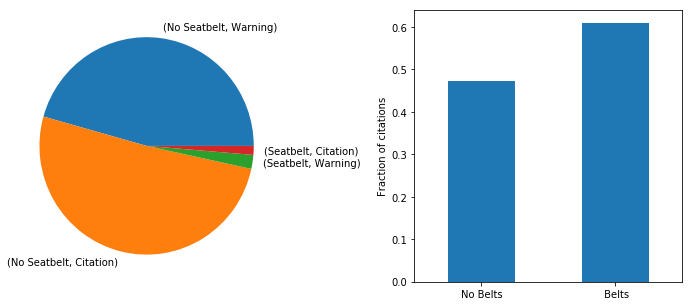

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, squeeze=False, figsize = [12, 5])
# use of seatbelt 
df = df_traffic.groupby(['Belts_Yes', 'Violation Type_Warning']).count()

df.index.set_levels([['No Seatbelt', 'Seatbelt'], 
                       ['Warning', 'Citation']], inplace=True)

df.Fatal_Yes.plot(kind = 'pie', legend = False, label = '', ax = axes[0,0])


# Wearing seat belt decreases the citation probability
df = df_traffic.groupby(['Belts_Yes', 'Violation Type_Warning']).count()

prop_no_Belts = df.loc[(0, 0),'Personal Injury_Yes']/\
                    [df.loc[(0, 0),'Personal Injury_Yes'] + df.loc[(0, 1),'Personal Injury_Yes']]
prop_Belts = df.loc[(1, 0),'Personal Injury_Yes']/\
                    [df.loc[(1, 0),'Personal Injury_Yes'] + df.loc[(1, 1),'Personal Injury_Yes']]

df1 = pd.DataFrame([prop_no_Belts, prop_Belts], index = ['No Belts', ' Belts'])
df1.plot(kind = 'bar', rot = 0, legend = False, ax = axes[0,1])
plt.ylabel('Fraction of citations')
plt.subplots_adjust(wspace = 0.5)
plt.show()

#### Women drive less but safe:

Driving is still considered as manly work in the US, and there is a preconception that men are better at driving. Further, [There is a study](https://www.dailymail.co.uk/sciencetech/article-2012188/Women-drivers-ARE-dangerous-wheel-scientists-discover.html) suggesting that women but are more dangerous drivers. My analysis tells just the opposite. Although women drive much less compared to men, they actually drive better and follows the rules. They are also less involved in dangerous accidents (even normalized by their driving population). They are also get less citations compared to men.

Another interesting fact is that women appear to get newer vehicle compared to men. 

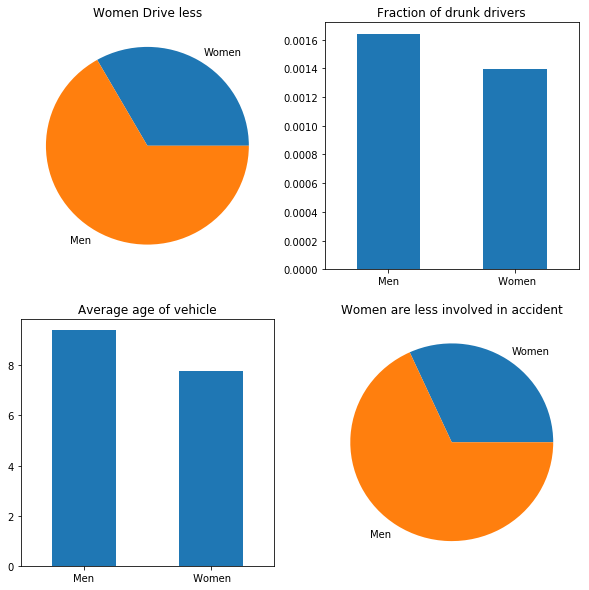

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize = [10, 10])

# Fraction of Male and female drivers
df = df_traffic.groupby(['Gender_M']).count()
df.index = ['Women', 'Men']
df.plot(kind = 'pie', y = 'Color', label = '', 
        legend = False, title = 'Women Drive less', ax = axes[0,0])

# women drive new cars
Vage_male = df_traffic[df_traffic.Gender_M == 1].V_Age.mean()
Vage_female = df_traffic[df_traffic.Gender_M == 0].V_Age.mean()

df1 = pd.DataFrame([Vage_male, Vage_female], index = ['Men', ' Women'])
s2 = df1.plot(kind = 'bar', legend = False, rot = 0, ax = axes[1,0],
              label = 'Agerage age of car',
              title = 'Average age of vehicle')

# Who don't use seatbelt?
df = df_traffic.groupby(['Gender_M', 'Alcohol_Yes']).count()

prop_female = df.loc[(0, 1),'Color']/\
                    [df.loc[(0, 0),'Color'] +\
                     df.loc[(0, 1),'Color']]
prop_male = df.loc[(1, 1),'Color']/\
                    [df.loc[(1, 0),'Color'] +\
                     df.loc[(1, 1),'Color']]

df1 = pd.DataFrame([prop_male, prop_female], index = ['Men', ' Women'])
s2 = df1.plot(kind = 'bar', legend = False, rot = 0, ax = axes[0, 1],
              title = 'Fraction of drunk drivers')

# Women are less involved in accidents and damages
danger_bool = (df_traffic['Personal Injury_Yes'] == 1) |\
              (df_traffic['Property Damage_Yes'] == 1) |\
              (df_traffic['Fatal_Yes'] == 1) |\
              (df_traffic['Contributed To Accident_Yes'] ==1)

df = df_traffic[danger_bool].groupby(['Gender_M']).count()
df.index = ['Women', 'Men']
df.plot(kind = 'pie', y = 'Color', label = '', ax = axes[1,1],
        legend = False, title = 'Women are less involved in accident')

plt.show()

Every months, there are around 15, 000 violations take place in Montgomery county, which amounts to one violation in every three minutes. But this number varies with season. More violation takes place in spring (Mar - May) compared to summer (June - Aug). Similarly, more violations occur in late night (after 10 pm) rather than the busy traffic hours. Both of these observations suggest that police officers become more stringent when the traffic is less dense. It is also possible that officers are busy on other activities during the peak hours.  

Among weekdays, violations are peaked on Tuesday and that drops slowly until the end of the week. It is interesting why number of violations on Monday is similar to the weekends. 

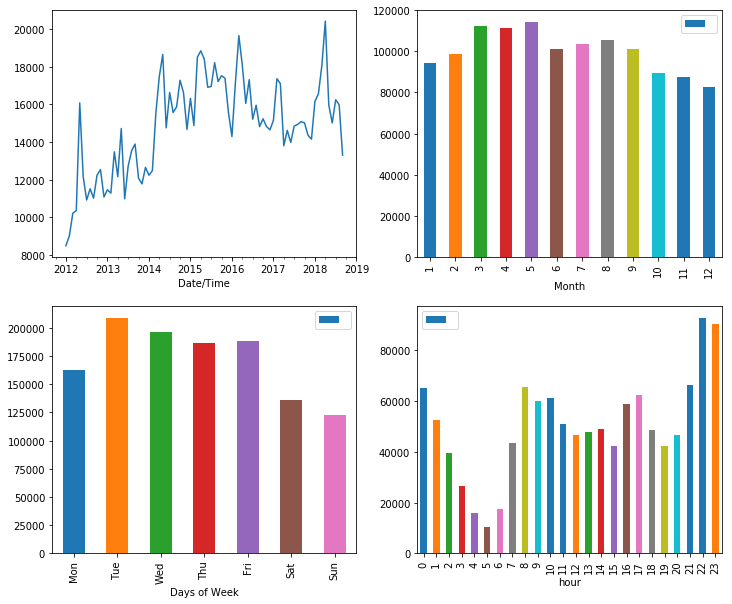

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize = [12, 10])

df_mon = df_traffic.resample('M').count()
df_mon.index.names = ['Date/Time']
df_mon.Belts_Yes.plot(ax = axes[0,0])

# Traffic violation by month
df_traffic['datetime'] = df_traffic.index
df_traffic['Month'] = df_traffic.datetime.dt.month

df_count_by_month = df_traffic.groupby('Month').count()

df_count_by_month.plot(kind = 'bar', y = 'Belts_Yes', label = '', ax = axes[0,1])
plt.ylabel('Violations')

# Traffic violation by day
df_traffic['day'] = df_traffic.datetime.dt.dayofweek
df_count_by_month = df_traffic.groupby('day').count()
df_count_by_month.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
df_count_by_month.index.names = ['Days of Week']

df_count_by_month.plot(kind = 'bar', y = 'Belts_Yes', label = '', ax = axes[1,0])
plt.xlabel('Day of Week')

# Traffic violation by hour
df_traffic['hour'] = df_traffic.datetime.dt.hour

df_count_by_month = df_traffic.groupby('hour').count()

df_count_by_month.plot( kind = 'bar', y = 'Belts_Yes', label = '', ax = axes[1,1])
plt.ylabel('')
plt.show()


### Citation probability: 

Not all the violations end up to citations. Some lucky drivers manage to receive just a warning, which gives them a great relief from paying an expensive fee or going to a court. In an ideal world, the probability of a driver getting a citation should only depend on the degree of violations he/she commits. But like every other human beings, police officers are biased on the drivers race, gender and the age of the vehicle. To quantitatively analyse the biasness of police officers on different socio/economic classes, I define a term <b>Citation Probability ($C_p$)</b>, which is a probability that a particular category gets citation after getting pulled over. 

\begin{equation*}
Cp   = \frac{N_c}{N_c + N_w}
\end{equation*}

where, $N_c$ and $N_w$ are respectively number of citations and number of warnings received by the driver belonging to a particular subgroup of a particular category. Below is a plot of citation probability for a few different categories.

### Who gets more citations?
The figure below display some useful comparisions: Male drivers gets more citations compared to females, which is not a surprise as we discussed earlier that women are better drivers. Note: there is an undefined (U) category which have very small citation probability but this could be an outlier since the population of drivers in this category is very small.

[There is a stereotype is that the Asians are bad drivers.](https://www.quora.com/Why-is-there-a-stereotype-that-Asians-are-bad-drivers-and-is-there-any-basis-for-this-in-reality). I find that the opposite is true. Asians receive much less citations compared to Hispanic, Blacks and even whites.  

Also, older vehicles are more likely to get citations compared to new vehicles. 

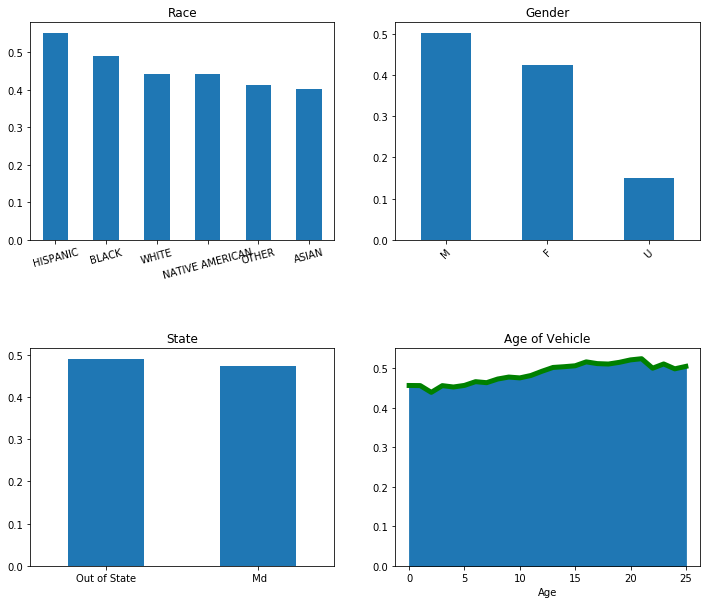

In [17]:
# initialize subplots
fig, axes = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize = [12, 10])

# plot the citation probability vs race
races = ['Race_BLACK', 'Race_HISPANIC','Race_NATIVE AMERICAN', 
         'Race_OTHER', 'Race_WHITE']

df_races = df_traffic.loc[:,races]
df_races['Race_ASIAN'] = 1 - df_races.sum(axis=1)
races = list(df_races.columns)

df_races['Violation Type_Warning'] = df_traffic['Violation Type_Warning']
df_races['extra_col'] = 1

cp = list()

for race in races:
    df = df_races.groupby([race, 'Violation Type_Warning']).count()
    prob = df.loc[(1, 0),'extra_col']/\
                    [df.loc[(1, 0),'extra_col'] +\
                     df.loc[(1, 1),'extra_col']]
    cp.append(float(prob))

races = [race[5:] for race in races]

df1 = pd.DataFrame(cp, index = races)
df1.sort_values(by = 0, ascending = False, inplace = True)
s1 = df1.plot(kind = 'bar', legend = False, rot = 15, 
              ax = axes[0,0], title = 'Race')

# plot the citation probability vs Gender
genders = ['Gender_U', 'Gender_M']
df_gender = df_traffic.loc[:, genders]
df_gender['Female'] = 1 - df_gender.sum(axis=1)

genders = list(df_gender.columns)
df_gender['Violation Type_Warning'] = df_traffic['Violation Type_Warning']
df_gender['extra_col'] = 1

cp = list()

for gender in genders:
    df = df_gender.groupby([gender, 'Violation Type_Warning']).count()
    prob = df.loc[(1, 0),'extra_col']/\
                 [df.loc[(1, 0),'extra_col'] + df.loc[(1, 1),'extra_col']]
    cp.append(float(prob))
    
df1 = pd.DataFrame(cp, index = ['U', 'M', 'F'])
df1.sort_values(by = 0, ascending = False, inplace = True)
s1 = df1.plot(kind = 'bar', legend = False, rot = 45, ax = axes[0,1],
               title = 'Gender')    

# plot the citation probability of Driver's license driver
df_state = df_traffic.groupby(['DL State_Out-ofSTATE', 'Violation Type_Warning']).count()

prop_state = df_state.loc[(0, 0),'Belts_Yes']/\
                    [df_state.loc[(0, 0),'Belts_Yes'] +\
                     df_state.loc[(0, 1),'Belts_Yes']]
prop_outstate = df_state.loc[(1, 0),'Belts_Yes']/\
                    [df_state.loc[(1, 0),'Belts_Yes'] +\
                     df_state.loc[(1, 1),'Belts_Yes']]
    
df1 = pd.DataFrame([prop_outstate, prop_state], index = ['Out of State', ' Md'])
s3 = df1.plot(kind = 'bar', legend = False, rot = 0, ax = axes[1,0], title = "State")

# plot citation probability vs age of vehicle
df = df_traffic.groupby(['V_Age', 'Violation Type_Warning']).count()
ct_prob = list()

n = 25
ages = np.linspace(0,n, n+1)

for age in ages:
    citation = df.loc[(age, 0), 'Belts_Yes']
    warning = df.loc[(age, 1), 'Belts_Yes']
    prob = citation/(citation + warning)
    ct_prob.append(prob)

V_age = pd.DataFrame({'Age':ages, 'Cp': ct_prob})
s4 = V_age.plot(kind = 'area', x = 'Age', y = 'Cp', ax  = axes[1,1], title = 'Age of Vehicle', legend = False)
plt.xticks = np.arange(0,25,6)
V_age.plot(x = 'Age', y = 'Cp', color = 'g', ax  = axes[1,1], linewidth = 5, legend = False)

plt.subplots_adjust(hspace = 0.5)
plt.show()

The citation probability not only compares the bias among differnt social classes, but also useful to understand how police officers respond at certain condition. This can be easily understood from the citation probability of all the categorical features in our data. 

The figure below tells us that drunk drivers or those involved in fatal accidents are much more likely  of receiving a traffic citation. It is also natural that violation in workplace increases the risk of receiving a citation. 

The citation probability is higher in the weekends rather than a busy weekday. This is probably because traffic officers are more active chasing drivers when the traffic is less crowded. 

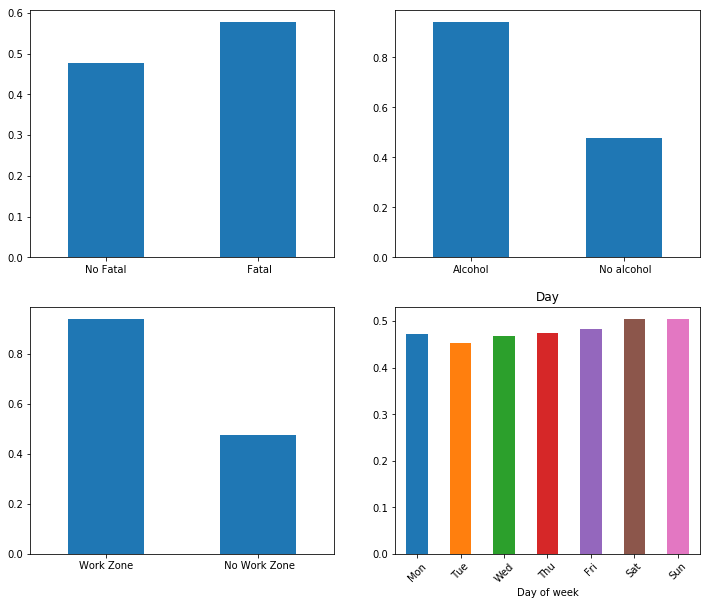

In [18]:
# initialize subplots
fig, axes = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize = [12, 10])

# Wearing seat belt decreases the citation probability
df = df_traffic.groupby(['Fatal_Yes', 'Violation Type_Warning']).count()

prop_no_Fatal = df.loc[(0, 0),'Personal Injury_Yes']/\
                    [df.loc[(0, 0),'Personal Injury_Yes'] + df.loc[(0, 1),'Personal Injury_Yes']]
prop_Fatal = df.loc[(1, 0),'Personal Injury_Yes']/\
                    [df.loc[(1, 0),'Personal Injury_Yes'] + df.loc[(1, 1),'Personal Injury_Yes']]

df1 = pd.DataFrame([prop_no_Fatal, prop_Fatal], index = ['No Fatal', ' Fatal'])
df1.plot(kind = 'bar', rot = 0, legend = False, ax = axes[0, 0])


# How does drinking alcochol effect the cp?
df = df_traffic.groupby(['Alcohol_Yes', 'Violation Type_Warning']).count()

prop_noalcohol = df.loc[(0, 0),'Belts_Yes']/\
                    [df.loc[(0, 0),'Belts_Yes'] + df.loc[(0, 1),'Belts_Yes']]
prop_alcohol = df.loc[(1, 0),'Belts_Yes']/\
                    [df.loc[(1, 0),'Belts_Yes'] + df.loc[(1, 1),'Belts_Yes']]

df1 = pd.DataFrame([prop_alcohol, prop_noalcohol], index = ['Alcohol', ' No alcohol'])
df1.plot(kind = 'bar', rot = 0, legend = False, ax = axes[0,1])

# is violation on work zone is different from other places?
df = df_traffic.groupby(['Work Zone_Yes', 'Violation Type_Warning']).count()

prop_work = df.loc[(0, 0),'Belts_Yes']/\
                    [df.loc[(0, 0),'Belts_Yes'] + df.loc[(0, 1),'Belts_Yes']]
prop_work = df.loc[(1, 0),'Belts_Yes']/\
                    [df.loc[(1, 0),'Belts_Yes'] + df.loc[(1, 1),'Belts_Yes']]

df1 = pd.DataFrame([prop_alcohol, prop_noalcohol], index = ['Work Zone', ' No Work Zone'])
df1.plot(kind = 'bar', rot = 0, legend = False, ax = axes[1,0])

# Is any day more likely to get tickets
df_traffic['datetime'] = df_traffic.index
df_traffic['day'] = df_traffic.datetime.dt.dayofweek

df = df_traffic.groupby(['day', 'Violation Type_Warning']).count()

ct_prob = list()
for i in range(7):
    prob = df.loc[(i, 0),'Belts_Yes']/\
                 [df.loc[(i, 0),'Belts_Yes'] + df.loc[(i, 1),'Belts_Yes']]
        
    ct_prob.append(float(prob))

days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
df = pd.DataFrame({'Day': days, 'cp': ct_prob})
df.plot(kind = 'bar', y = 'cp', x = 'Day', title = 'Day', rot = 45, 
        legend = False, ax = axes[1,1])   
plt.xlabel('Day of week')

plt.show()


The figure above shows citation probability of few categories. In the case of no bias, I would expect that the $C_p$ for all subgroups are equal. But we can see that there is a bias to some extent, which is not a surprise at all. 

## Non-Neutrality Index (NI)
These bar plot provide a great visualization for comparing the driving differences between subgroups of different categories. But it is not enough to quantitatively compare the extent of bias among different categories. For this purpose, I define a new term <b> non-Neutrality index (NI)</b>, which measures the amount of bias in a particular category. (I avoided the use of word bias since it may mean different in statistics)

\begin{equation*}
NI  = \frac{C_p^{max}}{C_p^{min}} - 1
\end{equation*}

where $C_p^{max}$ is the maximum probability within a category. For example, in the race category, $C_p^{male}$ = 0.6 and $C_p^{female}$ = 0.4, then $NI = \frac{0.6}{0.4} -1  = 0.5 $. If police officers are absolutely neutral within a particular category, NI would be zero.  

The higher value of NI means that police officer take this feature more seriously. For the purpose of machine learning, the higher values of NI are more useful feature since they contain more predictive power. The features with low NI are noise in this process and can be discarded. 


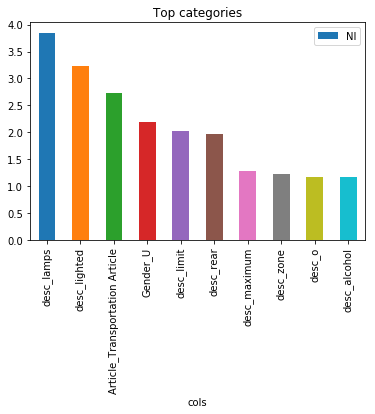

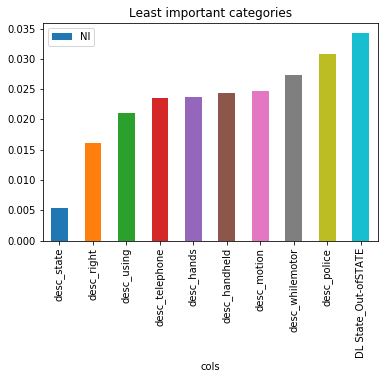

In [19]:
def non_neutrality_index(p1, p2):
    pmax = np.max([p1, p2])
    pmin = np.min([p1, p2])
    return pmax/pmin-1

df_traffic['extra_col'] = 0
col_of_interest = df_traffic.columns[:93]
col_of_interest = col_of_interest.drop(['Violation Type_Warning', 'Latitude', 
                                        'Longitude', 'Year', 'Make','Model', 'Color',
                                        'datetime', 'V_Age', 'Description'])


ni = list()
for col in col_of_interest:
    df = df_traffic.groupby([col, 'Violation Type_Warning']).count()
    
    prob1 = df.loc[(0, 0),'extra_col']/\
                    [df.loc[(0, 0),'extra_col'] +\
                     df.loc[(0, 1),'extra_col']]
    prob2 = df.loc[(1, 0),'extra_col']/\
                    [df.loc[(1, 0),'extra_col'] +\
                     df.loc[(1, 1),'extra_col']]
    
    ni.append(non_neutrality_index(prob1, prob2))
    
df_ni = pd.DataFrame({'cols': col_of_interest, 'NI': ni})

df_ni.sort_values('NI', ascending = False, inplace = True)
df_ni.iloc[:10,:].plot(kind = 'bar', x = 'cols', y = 'NI', rot = 90, title = 'Top categories')
plt.show()

df_ni.sort_values('NI', ascending = True, inplace = True)
df_ni.iloc[:10,:].plot(kind = 'bar', x = 'cols', y = 'NI', rot = 90, title = 'Least important categories')
plt.show()

The bar plot above provides ten most and ten least important categories to consider for machine learning. It also provides us a quantitative comparision between different features. 